## Pandas III: Concat, Append and Merge

*Disclaimer: The contents of this notebook are developped according to Python Data Science Handbook, by Jake VanderPlas and Python for Data Analysis, by Wes McKinney*

### Combining Datasets: Concat and Append
Some of the most interesting studies of data come from combining different data sources. Here we'll take a look at simple concatenation of `Series` and `DataFrames` with the `pd.concat()` function

In [2]:
import numpy as np
import pandas as pd

For convenience, we'll define this function which creates a `DataFrame` of a particular form that will be useful below

In [16]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


In addition, we'll create a quick class that allows us to display multiple DataFrames side by side. The code makes use of the special `_repr_html_` method, which IPython uses to implement its rich object display

In [17]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

### Recall: Concatenation of NumPy Arrays
Concatenation of `Series` and `DataFrame` objects is very similar to concatenation of Numpy arrays, which can be done via the `np.concatenate()` function

In [18]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
np.concatenate([x, y, z])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

The first argument is a `list` or `tuple` of arrays to concatenate. Additionally, it takes an `axis` keyword that allows you to specify the axis along which the result will be concatenated

In [19]:
x = [[1, 2],
     [3, 4]]
np.concatenate([x, x], axis = 1)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

### Simple Concatenation with `pd.concat`
Pandas has a function, `pd.concat()`, which has a similar syntax to `np.concatenate()`

**Syntax**

`pandas.concat(objs, axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, sort=False, copy=True)`

`pd.concat()` can be used for a simple concatenation of `Series` or `DataFrame` objects, just as `np.concatenate()` can be used for simple concatenations of arrays

In [20]:
ser1 = pd.Series(['A', 'B', 'C'], index = [1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index = [4, 5, 6])
pd.concat([ser1, ser2])

1    A
2    B
3    C
4    D
5    E
6    F
dtype: object

It also works to concatenate higher-dimensional objects, such as DataFrames

In [21]:
df1 = make_df('AB', [1, 2])
df2 = make_df('AB', [3, 4])
display('df1', 'df2', 'pd.concat([df1, df2])')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


By default, the concatenation takes place row-wise within the `DataFrame` (i.e., `axis = 0`). Like np.concatenate, `pd.concat()` allows specification of an axis along which concatenation will take place. Consider the following example

In [22]:
df3 = make_df('AB', [0, 1])
df4 = make_df('CD', [0, 1])
display('df3', 'df4', "pd.concat([df3, df4], axis = 1)")

df3
    A   B
0  A0  B0
1  A1  B1

df4
    C   D
0  C0  D0
1  C1  D1

pd.concat([df3, df4], axis = 1)
    A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1

#### Duplicate Indices
One important difference between `np.concatenate` and `pd.concat` is that Pandas concatenation preserves indices, even if the result will have duplicate indices! Consider this simple example

In [23]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make duplicate indices!
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


Notice the repeated indices in the result. While this is valid within DataFrames, the outcome is often undesirable. `pd.concat()` gives us a few ways to handle it

#### Catching the Repeats as an Error
If you'd like to simply verify that the indices in the result of `pd.concat()` do not overlap, you can specify the `verify_integrity` flag. With this set to `True`, the concatenation will raise an exception if there are duplicate indices

In [24]:
try:
    pd.concat([x, y], verify_integrity = True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the Index
Sometimes the index itself does not matter, and you would prefer it to simply be ignored. This option can be specified using the `ignore_index` flag. With this set to `True`, the concatenation will create a new integer index for the resulting `Series`

In [25]:
display('x', 'y', 'pd.concat([x, y], ignore_index = True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex Keys
Another option is to use the `keys` option to specify a label for the data sources; the result will be a hierarchically indexed series containing the data

In [26]:
display('x', 'y', "pd.concat([x, y], keys = ['x', 'y'])")

x
    A   B
0  A0  B0
1  A1  B1

y
    A   B
0  A2  B2
1  A3  B3

pd.concat([x, y], keys = ['x', 'y'])
      A   B
x 0  A0  B0
  1  A1  B1
y 0  A2  B2
  1  A3  B3

#### Concatenation with Joins
In the simple examples we just looked at, we were mainly concatenating DataFrames with shared column names. In practice, data from different sources might have different sets of column names, and `pd.concat` offers several options in this case. Consider the concatenation of the following two DataFrames, which have some (but not all!) columns in common

In [27]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6])
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

By default, the entries for which no data is available are filled with `NA` values. To change this, we can specify one of several options for the `join` parameter of the concatenate function. By default, the join is a union of the input columns (`join = 'outer'`), but we can change this to an intersection of the columns using `join = 'inner'`

In [28]:
display('df5', 'df6', "pd.concat([df5, df6], join = 'inner')")

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6], join = 'inner')
    B   C
1  B1  C1
2  B2  C2
3  B3  C3
4  B4  C4

#### The `append()` Method
`Series` and `DataFrame` objects have an `append()` method that can accomplish the same thing in fewer keystrokes. For example, rather than calling `pd.concat([df1, df2])`, you can simply call `df1.append(df2)`. Unlike the `append()` and `extend()` methods of Python lists, the `append()` method in Pandas does not modify the original object. Instead it creates a new object with the combined data

In [29]:
display('df1', 'df2', 'df1.append(df2)')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


### Combining Datasets: Merge and Join
The `pd.merge()` function implements a number of types of joins: the one-to-one, many-to-one, and many-to-many joins. All three types of joins are accessed via an identical call to the `pd.merge()` interface.

`merge(left, right, how = 'inner', on = None, left_on = None, right_on = None, left_index = False, right_index = False, sort = False, suffixes = ('_x', '_y'), copy = True, indicator = False, validate = None)`

<div>
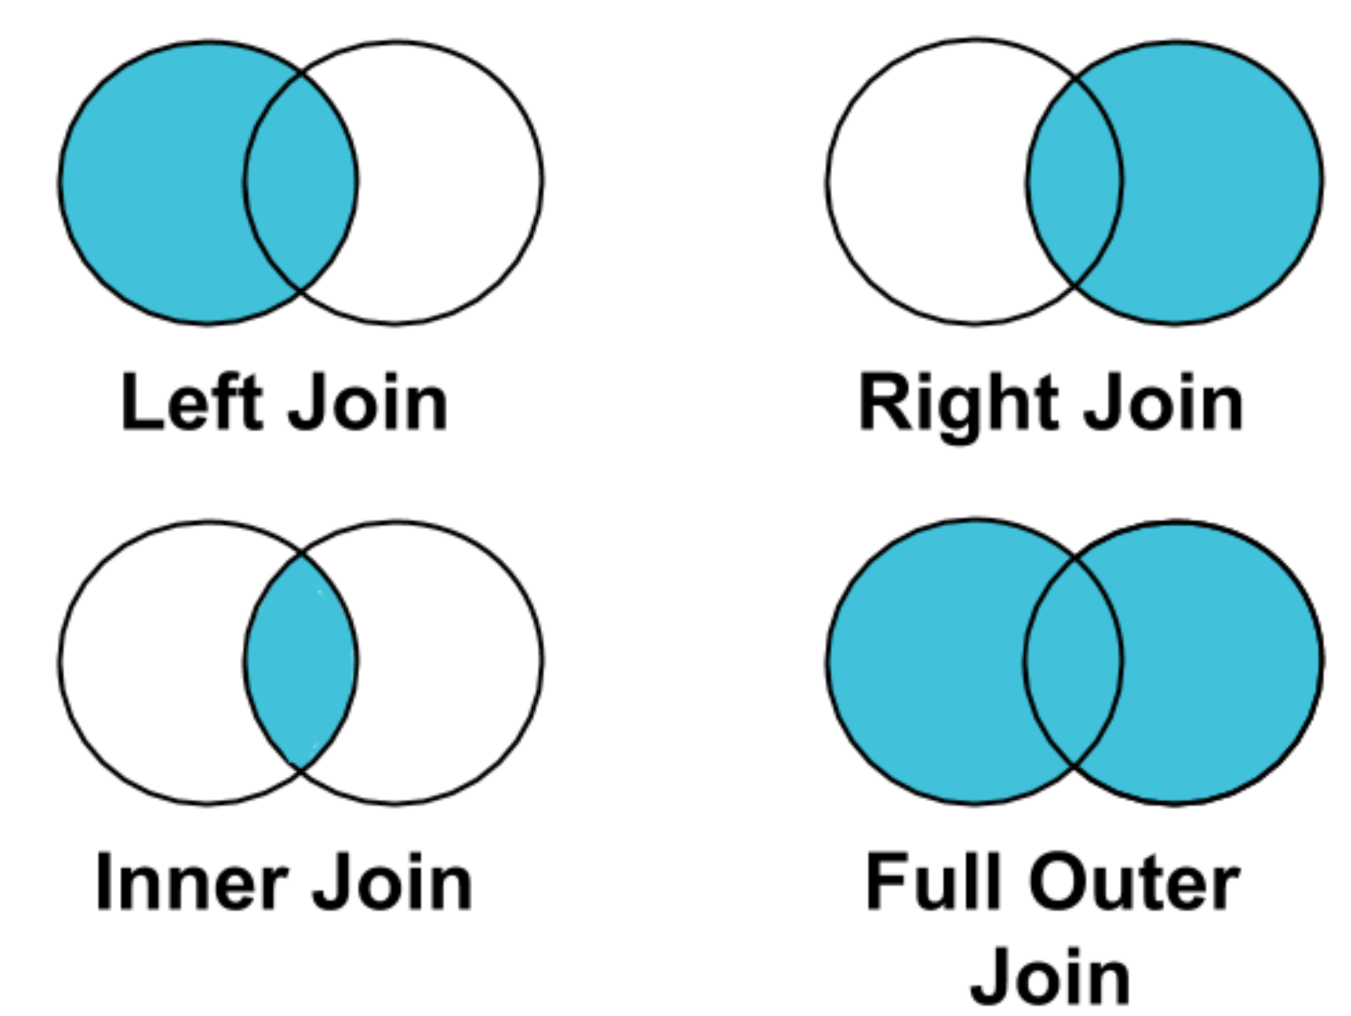
</div>

#### One-to-One Joins
The simplest type of merge expression is the one-to-one join, which is in many ways very similar to the **column-wise** concatenation.

In [30]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})
display('df1', 'df2', 'pd.merge(df1, df2)')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2)
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

To combine this information into a single `DataFrame`, we can use the `pd.merge()` function. The `pd.merge()` function recognizes that each `DataFrame` has an "employee" column, and automatically joins using this column as a key. The result of the merge is a new `DataFrame` that combines the information from the two inputs. Notice that the order of entries in each column is not necessarily maintained: in this case, the order of the "employee" column differs between df1 and df2, and the `pd.merge()` function correctly accounts for this. Additionally, keep in mind that the merge in general discards the index, except in the special case of merges by index (**when you are merging columns-on-columns, the indexes on the passed DataFrame objects are discarded**)

#### Many-to-One Joins
Many-to-one joins are joins in which one of the two key columns contains duplicate entries. For the many-to-one case, the resulting `DataFrame` will preserve those duplicate entries as appropriate

In [31]:
df4 = pd.DataFrame({'group': ['Accounting', 'Engineering', 'HR'],
                    'supervisor': ['Carly', 'Guido', 'Steve']})
display('df3', 'df4', 'pd.merge(df3, df4)')

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

The resulting `DataFrame` has an aditional column with the "supervisor" information, where the information is repeated in one or more locations as required by the inputs

#### Many-to-Many Joins
If the key column in both the left and right array contains duplicates, then the result is a many-to-many merge.

In [32]:
df5 = pd.DataFrame({'group': ['Accounting', 'Accounting',
                              'Engineering', 'Engineering', 'HR', 'HR'],
                    'skills': ['math', 'spreadsheets', 'coding', 'linux',
                               'spreadsheets', 'organization']})
display('df1', 'df5', "pd.merge(df1, df5)")

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR
,group,skills
0,Accounting,math
1,Accounting,spreadsheets
2,Engineering,coding
3,Engineering,linux
4,HR,spreadsheets


### Specification of the Merge Key
We've already seen the default behavior of `pd.merge()`: it looks for one or more matching column names between the two inputs, and uses this as the key. However, often the column names will not match so nicely, and `pd.merge()` provides a variety of options for handling this

#### The `on` Keyword
Most simply, you can explicitly specify the name of the key column using the `on` keyword, which takes **a column name or a list of column names**. This option works only if both the left and right DataFrames have the specified column name

In [33]:
display('df1', 'df2', "pd.merge(df1, df2, on = 'employee')")

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df2
  employee  hire_date
0     Lisa       2004
1      Bob       2008
2     Jake       2012
3      Sue       2014

pd.merge(df1, df2, on = 'employee')
  employee        group  hire_date
0      Bob   Accounting       2008
1     Jake  Engineering       2012
2     Lisa  Engineering       2004
3      Sue           HR       2014

#### The `left_on` and `right_on` Keywords
At times you may wish to merge two datasets with different column names; for example, we may have a dataset in which the employee name is labeled as "name" rather than "employee". In this case, we can use the `left_on` and `right_on` keywords to specify the two column names

In [34]:
df3 = pd.DataFrame({'name': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'salary': [70000, 80000, 120000, 90000]})
display('df1', 'df3', 'pd.merge(df1, df3, left_on = "employee", right_on = "name")')

df1
  employee        group
0      Bob   Accounting
1     Jake  Engineering
2     Lisa  Engineering
3      Sue           HR

df3
   name  salary
0   Bob   70000
1  Jake   80000
2  Lisa  120000
3   Sue   90000

pd.merge(df1, df3, left_on = "employee", right_on = "name")
  employee        group  name  salary
0      Bob   Accounting   Bob   70000
1     Jake  Engineering  Jake   80000
2     Lisa  Engineering  Lisa  120000
3      Sue           HR   Sue   90000

The result has a redundant column that we can drop if desired. For example, by using the `drop()` method of DataFrames

In [35]:
pd.merge(df1, df3, left_on = "employee", right_on = "name").drop('name', axis = 1)

,employee,group,salary
0,Bob,Accounting,70000
1,Jake,Engineering,80000
2,Lisa,Engineering,120000
3,Sue,HR,90000


#### The `left_index` and `right_index` Keywords
Sometimes, rather than merging on a column, you would instead like to merge on an index

In [36]:
df1

,employee,group
0,Bob,Accounting
1,Jake,Engineering
2,Lisa,Engineering
3,Sue,HR


In [37]:
df2

,employee,hire_date
0,Lisa,2004
1,Bob,2008
2,Jake,2012
3,Sue,2014


In [38]:
df1a = df1.set_index('employee')
df2a = df2.set_index('employee')
display('df1a', 'df2a')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


You can use the index as the key for merging by specifying the `left_index` and/or `right_index` flags in `pd.merge()`

In [39]:
display('df1a', 'df2a', "pd.merge(df1a, df2a, left_index = True, right_index = True)")

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


For convenience, DataFrames implement the `join()` method, which performs a merge that defaults to joining on indices

In [40]:
display('df1a', 'df2a', 'df1a.join(df2a)')

,group
employee,
Bob,Accounting
Jake,Engineering
Lisa,Engineering
Sue,HR
,hire_date
employee,
Lisa,2004
Bob,2008
Jake,2012


If you'd like to mix indices and columns, you can combine `left_index` with `right_on` or `left_on` with `right_index` to get the desired behavior

In [ ]:
# in the result, the labeled indexes of df1a are gone
display('df1a', 'df3', "pd.merge(df1a, df3, left_index = True, right_on = 'name')")

DataFrame's `join` method performs a left join on the join keys, exactly preserving the left frame's row index. It also supports joining the index of the passed DataFrame on one of the columns of the calling DataFrame

In [41]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                      'value': range(6)})
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [42]:
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])
right1

,group_val
a,3.5
b,7.0


In [43]:
pd.merge(left1, right1, left_on = 'key', right_index = True, how = 'outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


In [44]:
left1.join(right1, on = 'key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


#### Another Demo on `join`

In [ ]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                     index=['a', 'c', 'e'],
                     columns=['Ohio', 'Nevada'])
left2

In [ ]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                      index = ['b', 'c', 'd', 'e'],
                      columns = ['Missouri', 'Alabama'])
right2

In [ ]:
left2.join(right2)

In [ ]:
left2.join(right2, how = 'outer')

`join` can also be used to combine together many DataFrame objects having the same or similar indexes but non-overlapping columns. It can be used as an alternative to the more general `concat` method

In [ ]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                       index=['a', 'c', 'e', 'f'],
                       columns=['New York', 'Oregon'])
another

In [ ]:
left2.join([right2, another])

In [ ]:
left2.join([right2, another], how = 'outer')

### Merge with Multiple Keys
To merge with multiple keys, pass a list of column names

In [47]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [48]:
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [49]:
display('left', 'right', 'pd.merge(left, right, on = ["key1", "key2"], how = "outer")')

left
  key1 key2  lval
0  foo  one     1
1  foo  two     2
2  bar  one     3

right
  key1 key2  rval
0  foo  one     4
1  foo  one     5
2  bar  one     6
3  bar  two     7

pd.merge(left, right, on = ["key1", "key2"], how = "outer")
  key1 key2  lval  rval
0  foo  one   1.0   4.0
1  foo  one   1.0   5.0
2  foo  two   2.0   NaN
3  bar  one   3.0   6.0
4  bar  two   NaN   7.0

With hierarchically indexed data, things are more complicated, as joining on index is implicitly a multiple-key merge

In [50]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
                               'Nevada', 'Nevada'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})
lefth 

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [51]:
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index = [['Nevada', 'Nevada', 'Ohio', 'Ohio',
                              'Ohio', 'Ohio'],
                             [2001, 2000, 2000, 2000, 2001, 2002]],
                      columns = ['event1', 'event2'])
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In [52]:
display('lefth', 'righth', 'pd.merge(lefth, righth, left_on = ["key1", "key2"], right_index = True)')

lefth
     key1  key2  data
0    Ohio  2000   0.0
1    Ohio  2001   1.0
2    Ohio  2002   2.0
3  Nevada  2001   3.0
4  Nevada  2002   4.0

righth
             event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

pd.merge(lefth, righth, left_on = ["key1", "key2"], right_index = True)
     key1  key2  data  event1  event2
0    Ohio  2000   0.0       4       5
0    Ohio  2000   0.0       6       7
1    Ohio  2001   1.0       8       9
2    Ohio  2002   2.0      10      11
3  Nevada  2001   3.0       0       1

In [53]:
display('lefth', 'righth', 'pd.merge(lefth, righth, left_on = ["key1", "key2"], right_index = True, how = "outer")')

lefth
     key1  key2  data
0    Ohio  2000   0.0
1    Ohio  2001   1.0
2    Ohio  2002   2.0
3  Nevada  2001   3.0
4  Nevada  2002   4.0

righth
             event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

pd.merge(lefth, righth, left_on = ["key1", "key2"], right_index = True, how = "outer")
     key1  key2  data  event1  event2
0    Ohio  2000   0.0     4.0     5.0
0    Ohio  2000   0.0     6.0     7.0
1    Ohio  2001   1.0     8.0     9.0
2    Ohio  2002   2.0    10.0    11.0
3  Nevada  2001   3.0     0.0     1.0
4  Nevada  2002   4.0     NaN     NaN
4  Nevada  2000   NaN     2.0     3.0

### Case Study: US States Data
In this case study, we will consider an example of some data about US states and their populations.

In [46]:
# Following are shell commands to download the data
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-population.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-areas.csv
# !curl -O https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-abbrevs.csv

In [4]:
pop = pd.read_csv('state-population.csv')
areas = pd.read_csv('state-areas.csv')
abbrevs = pd.read_csv('state-abbrevs.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'state-population.csv'

In [ ]:
pop.head()

In [ ]:
areas.head()

In [ ]:
abbrevs.head()

#### Task 1: rank US states and territories by their 2010 population density

We'll start with a many-to-one merge that will give us the full state name within the population DataFrame. We want to merge based on the state/region column of pop, and the abbreviation column of abbrevs. We'll use `how = 'outer'` to make sure no data is thrown away due to mismatched labels

In [ ]:
merged = pd.merge(pop, abbrevs, how = 'outer', left_on = 'state/region', right_on = 'abbreviation')
merged.head()

In [ ]:
merged = merged.drop('abbreviation', axis = 1) # drop duplicate info
merged.head()

Let's double-check whether there were any mismatches here, which we can do by looking for rows with nulls

`isnull()`: Detect missing values for an array-like object

`any()`: Return whether any element is True, potentially over an axis

`DataFrame.any(axis=0, bool_only=None, skipna=True, level=None, **kwargs)`

axis: Indicate which axis or axes should be reduced, `{0 or 'index', 1 or 'columns', None}`, default 0
- `0 / 'index'` : reduce the index, return a Series whose index is the original column labels.
- `1 / 'columns'` : reduce the columns, return a Series whose index is the original index.

In [ ]:
merged.isnull().any()

In [ ]:
merged[merged['population'].isnull()]

It appears that all the null population values are from Puerto Rico prior to the year 2000; this is likely due to this data not being available from the original source.

More importantly, we see also that some of the new state entries are also null, which means that there was no corresponding entry in the abbrevs key! Let's figure out which regions lack this match

In [ ]:
# find out which state/region is missiing
merged.loc[merged['state'].isnull(), 'state/region'].unique()

We can quickly infer the issue: our population data includes entries for Puerto Rico (PR) and the United States as a whole (USA), while these entries do not appear in the state abbreviation key. We can fix these quickly by filling in appropriate entries

In [ ]:
merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
merged.isnull().any()

In [ ]:
merged.loc[merged['population'].isnull()]

In [ ]:
merged.dropna(inplace = True)

In [ ]:
merged.isnull().any()

Now we can merge the result with the area data using a similar procedure. Examining our results, we will want to join on the state column in both

In [ ]:
# how = 'left' : use only keys from left frame
final = pd.merge(merged, areas, on = 'state', how = 'left')
final.head()

Again, let's check for nulls to see if there were any mismatches

In [ ]:
final.isnull().any()

There are nulls in the `area` column; we can take a look to see which regions were ignored here

In [ ]:
final['state'][final['area (sq. mi)'].isnull()]

We see that our `areas` DataFrame does not contain the area of the United States as a whole. We could insert the appropriate value (using the sum of all state areas, for instance), but in this case we'll just drop the null values because the population density of the entire United States is not relevant to our current discussion

In [ ]:
final.dropna(inplace = True)
final.head()

Now we have all the data we need. To answer the question of interest, let's first select the portion of the data corresponding with the year 2000, and the total population. We'll use the `query()` function to do this

In [ ]:
data2010 = final.query("year == 2010 & ages == 'total'")
data2010.head()

Now let's compute the population density and display it in order. We'll start by re-indexing our data on the state, and then compute the result

In [ ]:
data2010.set_index('state', inplace = True)

In [ ]:
data2010.head()

In [ ]:
density = data2010['population'] / data2010['area (sq. mi)']

In [ ]:
density.sort_values(ascending = False, inplace = True)
density.head()

We can also check the end of the list

In [ ]:
density.tail()